In [1]:
%matplotlib inline
from pylab import *
import cv2
import rasterio

/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
rcParams['figure.figsize'] = 10, 10

In [3]:
from dataset import load_image

In [4]:
import torch

In [5]:
from utils import variable

In [6]:
from generate_masks import get_model

In [7]:
from torchvision.transforms import ToTensor, Normalize, Compose

In [8]:
img_transform = Compose([
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [9]:
from torch import nn
from torch.nn import functional as F
import torch
from torchvision import models
import torchvision
from unet_models import unet11

# model_path = 'data/models/unet16_binary_20/model_0.pt'
model_path = '../TernausNet/TernausNet.pt'
# model = get_model(model_path, model_type='UNet11', problem_type='binary') # errors with this!

# this is for the carvana/building model
# model =  unet11(pretrained='carvana')
# state = torch.load(model_path)
# model.load_state_dict(state['model'])

# start from only vgg
# model = unet11(pretrained=True)

# DEMO ALTERED. THESE CELLS GENERATE SOME DATA

In [10]:
# import the helper functions
from test_unet_helpers import *

import rasterio
import glob
import os,sys
#from skimage.transform import rescale, resize, downscale_local_mean
from matplotlib import pyplot as plt
import numpy as np
#from scipy import misc
import fiona
# import geopandas as gpd
from shapely.geometry import shape
import shapely
from rasterio.mask import mask
from pyproj import Proj, transform

/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [11]:
# specify scene id for DG data
dg_scene_id = '1030010057062200'

# specify image for 2.0 meter analysis
gt_image_2 = '../rasters/union_impervious_raster_2_0_0.tif' # desktop
gt_image_2 = '../rasters/union_impervious_raster_2_0_0_wgs84.tif' # desktop
# gt_image_2 = '../rasters/union_impervious_raster_2_0_0.tif' # laptop
#gt_image_2 = 'C:/projects/smart_cities/Denver_Sample_Sites/rasters/union_impervious_raster_2_0.tif'

# specify images for 0.5 meter analysis
gt_image_05 = '../rasters/union_impervious_raster_0_5.tif' # desktop
# gt_image_05 = '../rasters/union_impervious_raster_0_5.tif' # laptop
#gt_image_05 = 'C:/projects/smart_cities/Denver_Sample_Sites/rasters/union_impervious_raster_0_5.tif'

# specify the shapefile
# shpfile = '../Denver_Sample_Sites/union/union_grid_index256.shp'
shpfile = '../union/union.shp' # desktop
# shpfile = '../union/union.shp' # desktop
rows = []
with fiona.open(shpfile) as shp:
    crs = shp.crs
#     for s in shp:
#         # rows.append(shape(s['geometry']))
#         pass
        
        
    shp_bounds = shp.bounds

In [12]:
from gbdxtools import Interface, CatalogImage

# connect to gbdx
gbdx = Interface()

# get the dask array for the 8 band MS image
img_2m = CatalogImage(dg_scene_id, band_type='MS', bbox=shp_bounds, acomp=True)
rows, cols = img_2m.shape[1:]

# get the dask array for the Pansharpened, 4 band image
image_05m = CatalogImage(dg_scene_id, bbox=shp_bounds, acomp=True, pansharpen=True)
rowsP, colsP = image_05m.shape[1:]
pan_factorR = np.floor(rowsP/rows)
pan_factorC = np.floor(colsP/cols)

In [13]:
os.path.exists(gt_image_2)

True

In [14]:
# generate the sample points
# we have some funny stuff from ArcGIS converting the polygons to a raster... so... 
# generate the points within the bounds of the shapefile / DG image array

import random

random.seed(10)

num = 10000
side = 64
coords = []
coords_pan = []
im_patches = []
im_patches_pan = []

with rasterio.open(gt_image_2, 'r') as src:
    
    for i in range(num):
        ran_row, ran_col = random.randrange(0,rows), random.randrange(0,cols)
        print('generating sample {} of {}'.format(i+1, num))

        try:
            r_start = ran_row - side/2
            r_end = ran_row + side/2
            c_start = ran_col - side/2
            c_end = ran_col + side/2
            #im_data = img_2m[:, r_start:r_end, c_start:c_end]

            pr_start = ran_row*pan_factorR - side/2
            pr_end = ran_row*pan_factorR + side/2
            pc_start = ran_col*pan_factorC - side/2
            pc_end = ran_col*pan_factorC + side/2
            #im_data_pan = image_05m[:, pr_start:pr_end, pc_start:pc_end]

            # append regardless and check later.

            #############################################################################################################
            ### SHOULD CHECK THE INFORMATION THRESHOLDS BELOW, BUT HERE, TO RESELECT ROWS AND COLUMNS UNTIL IT IS MET ###
            #############################################################################################################

            s_pt = calcXYfromRC(img_2m.affine, (ran_row, ran_col))
            pt_flag = checkWindow(src, s_pt)
            ct = 0
            while pt_flag:
                ran_row, ran_col = random.randrange(0,rows), random.randrange(0,cols)
                s_pt = calcXYfromRC(img_2m.affine, (ran_row, ran_col))
                pt_flag = checkWindow(src, s_pt)
                
                ct+=1
                # exit loop after 1000 tries
                if ct > 1000:
                    break
            if ct > 1000:
                print('1000 tries, moving on')
                continue
                
                
            coords.append((ran_row, ran_col))
            coords_pan.append(( int(ran_row*pan_factorR), int(ran_col*pan_factorC)))

        except Exception as e:
            print(e)

    coords_arr = np.array(coords)  

generating sample 1 of 10000
generating sample 2 of 10000
generating sample 3 of 10000
generating sample 4 of 10000
generating sample 5 of 10000
generating sample 6 of 10000
generating sample 7 of 10000
generating sample 8 of 10000
generating sample 9 of 10000
generating sample 10 of 10000
generating sample 11 of 10000
generating sample 12 of 10000
generating sample 13 of 10000


/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


generating sample 14 of 10000
generating sample 15 of 10000
generating sample 16 of 10000
generating sample 17 of 10000
generating sample 18 of 10000
generating sample 19 of 10000
generating sample 20 of 10000
generating sample 21 of 10000
generating sample 22 of 10000
generating sample 23 of 10000
generating sample 24 of 10000
generating sample 25 of 10000
generating sample 26 of 10000
generating sample 27 of 10000
generating sample 28 of 10000
generating sample 29 of 10000
generating sample 30 of 10000
generating sample 31 of 10000
generating sample 32 of 10000
generating sample 33 of 10000
generating sample 34 of 10000
generating sample 35 of 10000
generating sample 36 of 10000
generating sample 37 of 10000
generating sample 38 of 10000
generating sample 39 of 10000
generating sample 40 of 10000
generating sample 41 of 10000
generating sample 42 of 10000
generating sample 43 of 10000
generating sample 44 of 10000
generating sample 45 of 10000
generating sample 46 of 10000
generating

generating sample 285 of 10000
generating sample 286 of 10000
generating sample 287 of 10000
generating sample 288 of 10000
generating sample 289 of 10000
generating sample 290 of 10000
generating sample 291 of 10000
generating sample 292 of 10000
generating sample 293 of 10000
generating sample 294 of 10000
generating sample 295 of 10000
generating sample 296 of 10000
generating sample 297 of 10000
generating sample 298 of 10000
generating sample 299 of 10000
generating sample 300 of 10000
generating sample 301 of 10000
generating sample 302 of 10000
generating sample 303 of 10000
generating sample 304 of 10000
generating sample 305 of 10000
generating sample 306 of 10000
generating sample 307 of 10000
generating sample 308 of 10000
generating sample 309 of 10000
generating sample 310 of 10000
generating sample 311 of 10000
generating sample 312 of 10000
generating sample 313 of 10000
generating sample 314 of 10000
generating sample 315 of 10000
generating sample 316 of 10000
generati

generating sample 557 of 10000
generating sample 558 of 10000
generating sample 559 of 10000
generating sample 560 of 10000
generating sample 561 of 10000
generating sample 562 of 10000
generating sample 563 of 10000
generating sample 564 of 10000
generating sample 565 of 10000
generating sample 566 of 10000
generating sample 567 of 10000
generating sample 568 of 10000
generating sample 569 of 10000
generating sample 570 of 10000
generating sample 571 of 10000
generating sample 572 of 10000
generating sample 573 of 10000
generating sample 574 of 10000
generating sample 575 of 10000
generating sample 576 of 10000
generating sample 577 of 10000
generating sample 578 of 10000
generating sample 579 of 10000
generating sample 580 of 10000
generating sample 581 of 10000
generating sample 582 of 10000
generating sample 583 of 10000
generating sample 584 of 10000
generating sample 585 of 10000
generating sample 586 of 10000
generating sample 587 of 10000
generating sample 588 of 10000
generati

generating sample 838 of 10000
generating sample 839 of 10000
generating sample 840 of 10000
generating sample 841 of 10000
generating sample 842 of 10000
generating sample 843 of 10000
generating sample 844 of 10000
generating sample 845 of 10000
generating sample 846 of 10000
generating sample 847 of 10000
generating sample 848 of 10000
generating sample 849 of 10000
generating sample 850 of 10000
generating sample 851 of 10000
generating sample 852 of 10000
generating sample 853 of 10000
generating sample 854 of 10000
generating sample 855 of 10000
generating sample 856 of 10000
generating sample 857 of 10000
generating sample 858 of 10000
generating sample 859 of 10000
generating sample 860 of 10000
generating sample 861 of 10000
generating sample 862 of 10000
generating sample 863 of 10000
generating sample 864 of 10000
generating sample 865 of 10000
generating sample 866 of 10000
generating sample 867 of 10000
generating sample 868 of 10000
generating sample 869 of 10000
generati

generating sample 1120 of 10000
generating sample 1121 of 10000
generating sample 1122 of 10000
generating sample 1123 of 10000
generating sample 1124 of 10000
generating sample 1125 of 10000
generating sample 1126 of 10000
generating sample 1127 of 10000
generating sample 1128 of 10000
generating sample 1129 of 10000
generating sample 1130 of 10000
generating sample 1131 of 10000
generating sample 1132 of 10000
generating sample 1133 of 10000
generating sample 1134 of 10000
generating sample 1135 of 10000
generating sample 1136 of 10000
generating sample 1137 of 10000
generating sample 1138 of 10000
generating sample 1139 of 10000
generating sample 1140 of 10000
generating sample 1141 of 10000
generating sample 1142 of 10000
generating sample 1143 of 10000
generating sample 1144 of 10000
generating sample 1145 of 10000
generating sample 1146 of 10000
generating sample 1147 of 10000
generating sample 1148 of 10000
generating sample 1149 of 10000
generating sample 1150 of 10000
generati

generating sample 1395 of 10000
generating sample 1396 of 10000
generating sample 1397 of 10000
generating sample 1398 of 10000
generating sample 1399 of 10000
generating sample 1400 of 10000
generating sample 1401 of 10000
generating sample 1402 of 10000
generating sample 1403 of 10000
generating sample 1404 of 10000
generating sample 1405 of 10000
generating sample 1406 of 10000
generating sample 1407 of 10000
generating sample 1408 of 10000
generating sample 1409 of 10000
generating sample 1410 of 10000
generating sample 1411 of 10000
generating sample 1412 of 10000
generating sample 1413 of 10000
generating sample 1414 of 10000
generating sample 1415 of 10000
generating sample 1416 of 10000
generating sample 1417 of 10000
generating sample 1418 of 10000
generating sample 1419 of 10000
generating sample 1420 of 10000
generating sample 1421 of 10000
generating sample 1422 of 10000
generating sample 1423 of 10000
generating sample 1424 of 10000
generating sample 1425 of 10000
generati

generating sample 1658 of 10000
generating sample 1659 of 10000
generating sample 1660 of 10000
generating sample 1661 of 10000
generating sample 1662 of 10000
generating sample 1663 of 10000
generating sample 1664 of 10000
generating sample 1665 of 10000
generating sample 1666 of 10000
generating sample 1667 of 10000
generating sample 1668 of 10000
generating sample 1669 of 10000
generating sample 1670 of 10000
generating sample 1671 of 10000
generating sample 1672 of 10000
generating sample 1673 of 10000
generating sample 1674 of 10000
generating sample 1675 of 10000
generating sample 1676 of 10000
generating sample 1677 of 10000
generating sample 1678 of 10000
generating sample 1679 of 10000
generating sample 1680 of 10000
generating sample 1681 of 10000
generating sample 1682 of 10000
generating sample 1683 of 10000
generating sample 1684 of 10000
generating sample 1685 of 10000
generating sample 1686 of 10000
generating sample 1687 of 10000
generating sample 1688 of 10000
generati

generating sample 1920 of 10000
generating sample 1921 of 10000
generating sample 1922 of 10000
generating sample 1923 of 10000
generating sample 1924 of 10000
generating sample 1925 of 10000
generating sample 1926 of 10000
generating sample 1927 of 10000
generating sample 1928 of 10000
generating sample 1929 of 10000
generating sample 1930 of 10000
generating sample 1931 of 10000
generating sample 1932 of 10000
generating sample 1933 of 10000
generating sample 1934 of 10000
generating sample 1935 of 10000
generating sample 1936 of 10000
generating sample 1937 of 10000
generating sample 1938 of 10000
generating sample 1939 of 10000
generating sample 1940 of 10000
generating sample 1941 of 10000
generating sample 1942 of 10000
generating sample 1943 of 10000
generating sample 1944 of 10000
generating sample 1945 of 10000
generating sample 1946 of 10000
generating sample 1947 of 10000
generating sample 1948 of 10000
generating sample 1949 of 10000
generating sample 1950 of 10000
generati

generating sample 2182 of 10000
generating sample 2183 of 10000
generating sample 2184 of 10000
generating sample 2185 of 10000
generating sample 2186 of 10000
generating sample 2187 of 10000
generating sample 2188 of 10000
generating sample 2189 of 10000
generating sample 2190 of 10000
generating sample 2191 of 10000
generating sample 2192 of 10000
generating sample 2193 of 10000
generating sample 2194 of 10000
generating sample 2195 of 10000
generating sample 2196 of 10000
generating sample 2197 of 10000
generating sample 2198 of 10000
generating sample 2199 of 10000
generating sample 2200 of 10000
generating sample 2201 of 10000
generating sample 2202 of 10000
generating sample 2203 of 10000
generating sample 2204 of 10000
generating sample 2205 of 10000
generating sample 2206 of 10000
generating sample 2207 of 10000
generating sample 2208 of 10000
generating sample 2209 of 10000
generating sample 2210 of 10000
generating sample 2211 of 10000
generating sample 2212 of 10000
generati

generating sample 2453 of 10000
generating sample 2454 of 10000
generating sample 2455 of 10000
generating sample 2456 of 10000
generating sample 2457 of 10000
generating sample 2458 of 10000
generating sample 2459 of 10000
generating sample 2460 of 10000
generating sample 2461 of 10000
generating sample 2462 of 10000
generating sample 2463 of 10000
generating sample 2464 of 10000
generating sample 2465 of 10000
generating sample 2466 of 10000
generating sample 2467 of 10000
generating sample 2468 of 10000
generating sample 2469 of 10000
generating sample 2470 of 10000
generating sample 2471 of 10000
generating sample 2472 of 10000
generating sample 2473 of 10000
generating sample 2474 of 10000
generating sample 2475 of 10000
generating sample 2476 of 10000
generating sample 2477 of 10000
generating sample 2478 of 10000
generating sample 2479 of 10000
generating sample 2480 of 10000
generating sample 2481 of 10000
generating sample 2482 of 10000
generating sample 2483 of 10000
generati

generating sample 2727 of 10000
generating sample 2728 of 10000
generating sample 2729 of 10000
generating sample 2730 of 10000
generating sample 2731 of 10000
generating sample 2732 of 10000
generating sample 2733 of 10000
generating sample 2734 of 10000
generating sample 2735 of 10000
generating sample 2736 of 10000
generating sample 2737 of 10000
generating sample 2738 of 10000
generating sample 2739 of 10000
generating sample 2740 of 10000
generating sample 2741 of 10000
generating sample 2742 of 10000
generating sample 2743 of 10000
generating sample 2744 of 10000
generating sample 2745 of 10000
generating sample 2746 of 10000
generating sample 2747 of 10000
generating sample 2748 of 10000
generating sample 2749 of 10000
generating sample 2750 of 10000
generating sample 2751 of 10000
generating sample 2752 of 10000
generating sample 2753 of 10000
generating sample 2754 of 10000
generating sample 2755 of 10000
generating sample 2756 of 10000
generating sample 2757 of 10000
generati

generating sample 2984 of 10000
generating sample 2985 of 10000
generating sample 2986 of 10000
generating sample 2987 of 10000
generating sample 2988 of 10000
generating sample 2989 of 10000
generating sample 2990 of 10000
generating sample 2991 of 10000
generating sample 2992 of 10000
generating sample 2993 of 10000
generating sample 2994 of 10000
generating sample 2995 of 10000
generating sample 2996 of 10000
generating sample 2997 of 10000
generating sample 2998 of 10000
generating sample 2999 of 10000
generating sample 3000 of 10000
generating sample 3001 of 10000
generating sample 3002 of 10000
generating sample 3003 of 10000
generating sample 3004 of 10000
generating sample 3005 of 10000
generating sample 3006 of 10000
generating sample 3007 of 10000
generating sample 3008 of 10000
generating sample 3009 of 10000
generating sample 3010 of 10000
generating sample 3011 of 10000
generating sample 3012 of 10000
generating sample 3013 of 10000
generating sample 3014 of 10000
generati

generating sample 3246 of 10000
generating sample 3247 of 10000
generating sample 3248 of 10000
generating sample 3249 of 10000
generating sample 3250 of 10000
generating sample 3251 of 10000
generating sample 3252 of 10000
generating sample 3253 of 10000
generating sample 3254 of 10000
generating sample 3255 of 10000
generating sample 3256 of 10000
generating sample 3257 of 10000
generating sample 3258 of 10000
generating sample 3259 of 10000
generating sample 3260 of 10000
generating sample 3261 of 10000
generating sample 3262 of 10000
generating sample 3263 of 10000
generating sample 3264 of 10000
generating sample 3265 of 10000
generating sample 3266 of 10000
generating sample 3267 of 10000
generating sample 3268 of 10000
generating sample 3269 of 10000
generating sample 3270 of 10000
generating sample 3271 of 10000
generating sample 3272 of 10000
generating sample 3273 of 10000
generating sample 3274 of 10000
generating sample 3275 of 10000
generating sample 3276 of 10000
generati

generating sample 3506 of 10000
generating sample 3507 of 10000
generating sample 3508 of 10000
generating sample 3509 of 10000
generating sample 3510 of 10000
generating sample 3511 of 10000
generating sample 3512 of 10000
generating sample 3513 of 10000
generating sample 3514 of 10000
generating sample 3515 of 10000
generating sample 3516 of 10000
generating sample 3517 of 10000
generating sample 3518 of 10000
generating sample 3519 of 10000
generating sample 3520 of 10000
generating sample 3521 of 10000
generating sample 3522 of 10000
generating sample 3523 of 10000
generating sample 3524 of 10000
generating sample 3525 of 10000
generating sample 3526 of 10000
generating sample 3527 of 10000
generating sample 3528 of 10000
generating sample 3529 of 10000
generating sample 3530 of 10000
generating sample 3531 of 10000
generating sample 3532 of 10000
generating sample 3533 of 10000
generating sample 3534 of 10000
generating sample 3535 of 10000
generating sample 3536 of 10000
generati

generating sample 3765 of 10000
generating sample 3766 of 10000
generating sample 3767 of 10000
generating sample 3768 of 10000
generating sample 3769 of 10000
generating sample 3770 of 10000
generating sample 3771 of 10000
generating sample 3772 of 10000
generating sample 3773 of 10000
generating sample 3774 of 10000
generating sample 3775 of 10000
generating sample 3776 of 10000
generating sample 3777 of 10000
generating sample 3778 of 10000
generating sample 3779 of 10000
generating sample 3780 of 10000
generating sample 3781 of 10000
generating sample 3782 of 10000
generating sample 3783 of 10000
generating sample 3784 of 10000
generating sample 3785 of 10000
generating sample 3786 of 10000
generating sample 3787 of 10000
generating sample 3788 of 10000
generating sample 3789 of 10000
generating sample 3790 of 10000
generating sample 3791 of 10000
generating sample 3792 of 10000
generating sample 3793 of 10000
generating sample 3794 of 10000
generating sample 3795 of 10000
generati

generating sample 4022 of 10000
generating sample 4023 of 10000
generating sample 4024 of 10000
generating sample 4025 of 10000
generating sample 4026 of 10000
generating sample 4027 of 10000
generating sample 4028 of 10000
generating sample 4029 of 10000
generating sample 4030 of 10000
generating sample 4031 of 10000
generating sample 4032 of 10000
generating sample 4033 of 10000
generating sample 4034 of 10000
generating sample 4035 of 10000
generating sample 4036 of 10000
generating sample 4037 of 10000
generating sample 4038 of 10000
generating sample 4039 of 10000
generating sample 4040 of 10000
generating sample 4041 of 10000
generating sample 4042 of 10000
generating sample 4043 of 10000
generating sample 4044 of 10000
generating sample 4045 of 10000
generating sample 4046 of 10000
generating sample 4047 of 10000
generating sample 4048 of 10000
generating sample 4049 of 10000
generating sample 4050 of 10000
generating sample 4051 of 10000
generating sample 4052 of 10000
generati

generating sample 4280 of 10000
generating sample 4281 of 10000
generating sample 4282 of 10000
generating sample 4283 of 10000
generating sample 4284 of 10000
generating sample 4285 of 10000
generating sample 4286 of 10000
generating sample 4287 of 10000
generating sample 4288 of 10000
generating sample 4289 of 10000
generating sample 4290 of 10000
generating sample 4291 of 10000
generating sample 4292 of 10000
generating sample 4293 of 10000
generating sample 4294 of 10000
generating sample 4295 of 10000
generating sample 4296 of 10000
generating sample 4297 of 10000
generating sample 4298 of 10000
generating sample 4299 of 10000
generating sample 4300 of 10000
generating sample 4301 of 10000
generating sample 4302 of 10000
generating sample 4303 of 10000
generating sample 4304 of 10000
generating sample 4305 of 10000
generating sample 4306 of 10000
generating sample 4307 of 10000
generating sample 4308 of 10000
generating sample 4309 of 10000
generating sample 4310 of 10000
generati

generating sample 4553 of 10000
generating sample 4554 of 10000
generating sample 4555 of 10000
generating sample 4556 of 10000
generating sample 4557 of 10000
generating sample 4558 of 10000
generating sample 4559 of 10000
generating sample 4560 of 10000
generating sample 4561 of 10000
generating sample 4562 of 10000
generating sample 4563 of 10000
generating sample 4564 of 10000
generating sample 4565 of 10000
generating sample 4566 of 10000
generating sample 4567 of 10000
generating sample 4568 of 10000
generating sample 4569 of 10000
generating sample 4570 of 10000
generating sample 4571 of 10000
generating sample 4572 of 10000
generating sample 4573 of 10000
generating sample 4574 of 10000
generating sample 4575 of 10000
generating sample 4576 of 10000
generating sample 4577 of 10000
generating sample 4578 of 10000
generating sample 4579 of 10000
generating sample 4580 of 10000
generating sample 4581 of 10000
generating sample 4582 of 10000
generating sample 4583 of 10000
generati

generating sample 4811 of 10000
generating sample 4812 of 10000
generating sample 4813 of 10000
generating sample 4814 of 10000
generating sample 4815 of 10000
generating sample 4816 of 10000
generating sample 4817 of 10000
generating sample 4818 of 10000
generating sample 4819 of 10000
generating sample 4820 of 10000
generating sample 4821 of 10000
generating sample 4822 of 10000
generating sample 4823 of 10000
generating sample 4824 of 10000
generating sample 4825 of 10000
generating sample 4826 of 10000
generating sample 4827 of 10000
generating sample 4828 of 10000
generating sample 4829 of 10000
generating sample 4830 of 10000
generating sample 4831 of 10000
generating sample 4832 of 10000
generating sample 4833 of 10000
generating sample 4834 of 10000
generating sample 4835 of 10000
generating sample 4836 of 10000
generating sample 4837 of 10000
generating sample 4838 of 10000
generating sample 4839 of 10000
generating sample 4840 of 10000
generating sample 4841 of 10000
generati

generating sample 5070 of 10000
generating sample 5071 of 10000
generating sample 5072 of 10000
generating sample 5073 of 10000
generating sample 5074 of 10000
generating sample 5075 of 10000
generating sample 5076 of 10000
generating sample 5077 of 10000
generating sample 5078 of 10000
generating sample 5079 of 10000
generating sample 5080 of 10000
generating sample 5081 of 10000
generating sample 5082 of 10000
generating sample 5083 of 10000
generating sample 5084 of 10000
generating sample 5085 of 10000
generating sample 5086 of 10000
generating sample 5087 of 10000
generating sample 5088 of 10000
generating sample 5089 of 10000
generating sample 5090 of 10000
generating sample 5091 of 10000
generating sample 5092 of 10000
generating sample 5093 of 10000
generating sample 5094 of 10000
generating sample 5095 of 10000
generating sample 5096 of 10000
generating sample 5097 of 10000
generating sample 5098 of 10000
generating sample 5099 of 10000
generating sample 5100 of 10000
generati

generating sample 5345 of 10000
generating sample 5346 of 10000
generating sample 5347 of 10000
generating sample 5348 of 10000
generating sample 5349 of 10000
generating sample 5350 of 10000
generating sample 5351 of 10000
generating sample 5352 of 10000
generating sample 5353 of 10000
generating sample 5354 of 10000
generating sample 5355 of 10000
generating sample 5356 of 10000
generating sample 5357 of 10000
generating sample 5358 of 10000
generating sample 5359 of 10000
generating sample 5360 of 10000
generating sample 5361 of 10000
generating sample 5362 of 10000
generating sample 5363 of 10000
generating sample 5364 of 10000
generating sample 5365 of 10000
generating sample 5366 of 10000
generating sample 5367 of 10000
generating sample 5368 of 10000
generating sample 5369 of 10000
generating sample 5370 of 10000
generating sample 5371 of 10000
generating sample 5372 of 10000
generating sample 5373 of 10000
generating sample 5374 of 10000
generating sample 5375 of 10000
generati

generating sample 5607 of 10000
generating sample 5608 of 10000
generating sample 5609 of 10000
generating sample 5610 of 10000
generating sample 5611 of 10000
generating sample 5612 of 10000
generating sample 5613 of 10000
generating sample 5614 of 10000
generating sample 5615 of 10000
generating sample 5616 of 10000
generating sample 5617 of 10000
generating sample 5618 of 10000
generating sample 5619 of 10000
generating sample 5620 of 10000
generating sample 5621 of 10000
generating sample 5622 of 10000
generating sample 5623 of 10000
generating sample 5624 of 10000
generating sample 5625 of 10000
generating sample 5626 of 10000
generating sample 5627 of 10000
generating sample 5628 of 10000
generating sample 5629 of 10000
generating sample 5630 of 10000
generating sample 5631 of 10000
generating sample 5632 of 10000
generating sample 5633 of 10000
generating sample 5634 of 10000
generating sample 5635 of 10000
generating sample 5636 of 10000
generating sample 5637 of 10000
generati

generating sample 5881 of 10000
generating sample 5882 of 10000
generating sample 5883 of 10000
generating sample 5884 of 10000
generating sample 5885 of 10000
generating sample 5886 of 10000
generating sample 5887 of 10000
generating sample 5888 of 10000
generating sample 5889 of 10000
generating sample 5890 of 10000
generating sample 5891 of 10000
generating sample 5892 of 10000
generating sample 5893 of 10000
generating sample 5894 of 10000
generating sample 5895 of 10000
generating sample 5896 of 10000
generating sample 5897 of 10000
generating sample 5898 of 10000
generating sample 5899 of 10000
generating sample 5900 of 10000
generating sample 5901 of 10000
generating sample 5902 of 10000
generating sample 5903 of 10000
generating sample 5904 of 10000
generating sample 5905 of 10000
generating sample 5906 of 10000
generating sample 5907 of 10000
generating sample 5908 of 10000
generating sample 5909 of 10000
generating sample 5910 of 10000
generating sample 5911 of 10000
generati

generating sample 6155 of 10000
generating sample 6156 of 10000
generating sample 6157 of 10000
generating sample 6158 of 10000
generating sample 6159 of 10000
generating sample 6160 of 10000
generating sample 6161 of 10000
generating sample 6162 of 10000
generating sample 6163 of 10000
generating sample 6164 of 10000
generating sample 6165 of 10000
generating sample 6166 of 10000
generating sample 6167 of 10000
generating sample 6168 of 10000
generating sample 6169 of 10000
generating sample 6170 of 10000
generating sample 6171 of 10000
generating sample 6172 of 10000
generating sample 6173 of 10000
generating sample 6174 of 10000
generating sample 6175 of 10000
generating sample 6176 of 10000
generating sample 6177 of 10000
generating sample 6178 of 10000
generating sample 6179 of 10000
generating sample 6180 of 10000
generating sample 6181 of 10000
generating sample 6182 of 10000
generating sample 6183 of 10000
generating sample 6184 of 10000
generating sample 6185 of 10000
generati

generating sample 6421 of 10000
generating sample 6422 of 10000
generating sample 6423 of 10000
generating sample 6424 of 10000
generating sample 6425 of 10000
generating sample 6426 of 10000
generating sample 6427 of 10000
generating sample 6428 of 10000
generating sample 6429 of 10000
generating sample 6430 of 10000
generating sample 6431 of 10000
generating sample 6432 of 10000
generating sample 6433 of 10000
generating sample 6434 of 10000
generating sample 6435 of 10000
generating sample 6436 of 10000
generating sample 6437 of 10000
generating sample 6438 of 10000
generating sample 6439 of 10000
generating sample 6440 of 10000
generating sample 6441 of 10000
generating sample 6442 of 10000
generating sample 6443 of 10000
generating sample 6444 of 10000
generating sample 6445 of 10000
generating sample 6446 of 10000
generating sample 6447 of 10000
generating sample 6448 of 10000
generating sample 6449 of 10000
generating sample 6450 of 10000
generating sample 6451 of 10000
generati

generating sample 6690 of 10000
generating sample 6691 of 10000
generating sample 6692 of 10000
generating sample 6693 of 10000
generating sample 6694 of 10000
generating sample 6695 of 10000
generating sample 6696 of 10000
generating sample 6697 of 10000
generating sample 6698 of 10000
generating sample 6699 of 10000
generating sample 6700 of 10000
generating sample 6701 of 10000
generating sample 6702 of 10000
generating sample 6703 of 10000
generating sample 6704 of 10000
generating sample 6705 of 10000
generating sample 6706 of 10000
generating sample 6707 of 10000
generating sample 6708 of 10000
generating sample 6709 of 10000
generating sample 6710 of 10000
generating sample 6711 of 10000
generating sample 6712 of 10000
generating sample 6713 of 10000
generating sample 6714 of 10000
generating sample 6715 of 10000
generating sample 6716 of 10000
generating sample 6717 of 10000
generating sample 6718 of 10000
generating sample 6719 of 10000
generating sample 6720 of 10000
generati

generating sample 6968 of 10000
generating sample 6969 of 10000
generating sample 6970 of 10000
generating sample 6971 of 10000
generating sample 6972 of 10000
generating sample 6973 of 10000
generating sample 6974 of 10000
generating sample 6975 of 10000
generating sample 6976 of 10000
generating sample 6977 of 10000
generating sample 6978 of 10000
generating sample 6979 of 10000
generating sample 6980 of 10000
generating sample 6981 of 10000
generating sample 6982 of 10000
generating sample 6983 of 10000
generating sample 6984 of 10000
generating sample 6985 of 10000
generating sample 6986 of 10000
generating sample 6987 of 10000
generating sample 6988 of 10000
generating sample 6989 of 10000
generating sample 6990 of 10000
generating sample 6991 of 10000
generating sample 6992 of 10000
generating sample 6993 of 10000
generating sample 6994 of 10000
generating sample 6995 of 10000
generating sample 6996 of 10000
generating sample 6997 of 10000
generating sample 6998 of 10000
generati

generating sample 7226 of 10000
generating sample 7227 of 10000
generating sample 7228 of 10000
generating sample 7229 of 10000
generating sample 7230 of 10000
generating sample 7231 of 10000
generating sample 7232 of 10000
generating sample 7233 of 10000
generating sample 7234 of 10000
generating sample 7235 of 10000
generating sample 7236 of 10000
generating sample 7237 of 10000
generating sample 7238 of 10000
generating sample 7239 of 10000
generating sample 7240 of 10000
generating sample 7241 of 10000
generating sample 7242 of 10000
generating sample 7243 of 10000
generating sample 7244 of 10000
generating sample 7245 of 10000
generating sample 7246 of 10000
generating sample 7247 of 10000
generating sample 7248 of 10000
generating sample 7249 of 10000
generating sample 7250 of 10000
generating sample 7251 of 10000
generating sample 7252 of 10000
generating sample 7253 of 10000
generating sample 7254 of 10000
generating sample 7255 of 10000
generating sample 7256 of 10000
generati

generating sample 7493 of 10000
generating sample 7494 of 10000
generating sample 7495 of 10000
generating sample 7496 of 10000
generating sample 7497 of 10000
generating sample 7498 of 10000
generating sample 7499 of 10000
generating sample 7500 of 10000
generating sample 7501 of 10000
generating sample 7502 of 10000
generating sample 7503 of 10000
generating sample 7504 of 10000
generating sample 7505 of 10000
generating sample 7506 of 10000
generating sample 7507 of 10000
generating sample 7508 of 10000
generating sample 7509 of 10000
generating sample 7510 of 10000
generating sample 7511 of 10000
generating sample 7512 of 10000
generating sample 7513 of 10000
generating sample 7514 of 10000
generating sample 7515 of 10000
generating sample 7516 of 10000
generating sample 7517 of 10000
generating sample 7518 of 10000
generating sample 7519 of 10000
generating sample 7520 of 10000
generating sample 7521 of 10000
generating sample 7522 of 10000
generating sample 7523 of 10000
generati

generating sample 7752 of 10000
generating sample 7753 of 10000
generating sample 7754 of 10000
generating sample 7755 of 10000
generating sample 7756 of 10000
generating sample 7757 of 10000
generating sample 7758 of 10000
generating sample 7759 of 10000
generating sample 7760 of 10000
generating sample 7761 of 10000
generating sample 7762 of 10000
generating sample 7763 of 10000
generating sample 7764 of 10000
generating sample 7765 of 10000
generating sample 7766 of 10000
generating sample 7767 of 10000
generating sample 7768 of 10000
generating sample 7769 of 10000
generating sample 7770 of 10000
generating sample 7771 of 10000
generating sample 7772 of 10000
generating sample 7773 of 10000
generating sample 7774 of 10000
generating sample 7775 of 10000
generating sample 7776 of 10000
generating sample 7777 of 10000
generating sample 7778 of 10000
generating sample 7779 of 10000
generating sample 7780 of 10000
generating sample 7781 of 10000
generating sample 7782 of 10000
generati

generating sample 8012 of 10000
generating sample 8013 of 10000
generating sample 8014 of 10000
generating sample 8015 of 10000
generating sample 8016 of 10000
generating sample 8017 of 10000
generating sample 8018 of 10000
generating sample 8019 of 10000
generating sample 8020 of 10000
generating sample 8021 of 10000
generating sample 8022 of 10000
generating sample 8023 of 10000
generating sample 8024 of 10000
generating sample 8025 of 10000
generating sample 8026 of 10000
generating sample 8027 of 10000
generating sample 8028 of 10000
generating sample 8029 of 10000
generating sample 8030 of 10000
generating sample 8031 of 10000
generating sample 8032 of 10000
generating sample 8033 of 10000
generating sample 8034 of 10000
generating sample 8035 of 10000
generating sample 8036 of 10000
generating sample 8037 of 10000
generating sample 8038 of 10000
generating sample 8039 of 10000
generating sample 8040 of 10000
generating sample 8041 of 10000
generating sample 8042 of 10000
generati

generating sample 8285 of 10000
generating sample 8286 of 10000
generating sample 8287 of 10000
generating sample 8288 of 10000
generating sample 8289 of 10000
generating sample 8290 of 10000
generating sample 8291 of 10000
generating sample 8292 of 10000
generating sample 8293 of 10000
generating sample 8294 of 10000
generating sample 8295 of 10000
generating sample 8296 of 10000
generating sample 8297 of 10000
generating sample 8298 of 10000
generating sample 8299 of 10000
generating sample 8300 of 10000
generating sample 8301 of 10000
generating sample 8302 of 10000
generating sample 8303 of 10000
generating sample 8304 of 10000
generating sample 8305 of 10000
generating sample 8306 of 10000
generating sample 8307 of 10000
generating sample 8308 of 10000
generating sample 8309 of 10000
generating sample 8310 of 10000
generating sample 8311 of 10000
generating sample 8312 of 10000
generating sample 8313 of 10000
generating sample 8314 of 10000
generating sample 8315 of 10000
generati

generating sample 8544 of 10000
generating sample 8545 of 10000
generating sample 8546 of 10000
generating sample 8547 of 10000
generating sample 8548 of 10000
generating sample 8549 of 10000
generating sample 8550 of 10000
generating sample 8551 of 10000
generating sample 8552 of 10000
generating sample 8553 of 10000
generating sample 8554 of 10000
generating sample 8555 of 10000
generating sample 8556 of 10000
generating sample 8557 of 10000
generating sample 8558 of 10000
generating sample 8559 of 10000
generating sample 8560 of 10000
generating sample 8561 of 10000
generating sample 8562 of 10000
generating sample 8563 of 10000
generating sample 8564 of 10000
generating sample 8565 of 10000
generating sample 8566 of 10000
generating sample 8567 of 10000
generating sample 8568 of 10000
generating sample 8569 of 10000
generating sample 8570 of 10000
generating sample 8571 of 10000
generating sample 8572 of 10000
generating sample 8573 of 10000
generating sample 8574 of 10000
generati

generating sample 8811 of 10000
generating sample 8812 of 10000
generating sample 8813 of 10000
generating sample 8814 of 10000
generating sample 8815 of 10000
generating sample 8816 of 10000
generating sample 8817 of 10000
generating sample 8818 of 10000
generating sample 8819 of 10000
generating sample 8820 of 10000
generating sample 8821 of 10000
generating sample 8822 of 10000
generating sample 8823 of 10000
generating sample 8824 of 10000
generating sample 8825 of 10000
generating sample 8826 of 10000
generating sample 8827 of 10000
generating sample 8828 of 10000
generating sample 8829 of 10000
generating sample 8830 of 10000
generating sample 8831 of 10000
generating sample 8832 of 10000
generating sample 8833 of 10000
generating sample 8834 of 10000
generating sample 8835 of 10000
generating sample 8836 of 10000
generating sample 8837 of 10000
generating sample 8838 of 10000
generating sample 8839 of 10000
generating sample 8840 of 10000
generating sample 8841 of 10000
generati

generating sample 9077 of 10000
generating sample 9078 of 10000
generating sample 9079 of 10000
generating sample 9080 of 10000
generating sample 9081 of 10000
generating sample 9082 of 10000
generating sample 9083 of 10000
generating sample 9084 of 10000
generating sample 9085 of 10000
generating sample 9086 of 10000
generating sample 9087 of 10000
generating sample 9088 of 10000
generating sample 9089 of 10000
generating sample 9090 of 10000
generating sample 9091 of 10000
generating sample 9092 of 10000
generating sample 9093 of 10000
generating sample 9094 of 10000
generating sample 9095 of 10000
generating sample 9096 of 10000
generating sample 9097 of 10000
generating sample 9098 of 10000
generating sample 9099 of 10000
generating sample 9100 of 10000
generating sample 9101 of 10000
generating sample 9102 of 10000
generating sample 9103 of 10000
generating sample 9104 of 10000
generating sample 9105 of 10000
generating sample 9106 of 10000
generating sample 9107 of 10000
generati

generating sample 9342 of 10000
generating sample 9343 of 10000
generating sample 9344 of 10000
generating sample 9345 of 10000
generating sample 9346 of 10000
generating sample 9347 of 10000
generating sample 9348 of 10000
generating sample 9349 of 10000
generating sample 9350 of 10000
generating sample 9351 of 10000
generating sample 9352 of 10000
generating sample 9353 of 10000
generating sample 9354 of 10000
generating sample 9355 of 10000
generating sample 9356 of 10000
generating sample 9357 of 10000
generating sample 9358 of 10000
generating sample 9359 of 10000
generating sample 9360 of 10000
generating sample 9361 of 10000
generating sample 9362 of 10000
generating sample 9363 of 10000
generating sample 9364 of 10000
generating sample 9365 of 10000
generating sample 9366 of 10000
generating sample 9367 of 10000
generating sample 9368 of 10000
generating sample 9369 of 10000
generating sample 9370 of 10000
generating sample 9371 of 10000
generating sample 9372 of 10000
generati

generating sample 9615 of 10000
generating sample 9616 of 10000
generating sample 9617 of 10000
generating sample 9618 of 10000
generating sample 9619 of 10000
generating sample 9620 of 10000
generating sample 9621 of 10000
generating sample 9622 of 10000
generating sample 9623 of 10000
generating sample 9624 of 10000
generating sample 9625 of 10000
generating sample 9626 of 10000
generating sample 9627 of 10000
generating sample 9628 of 10000
generating sample 9629 of 10000
generating sample 9630 of 10000
generating sample 9631 of 10000
generating sample 9632 of 10000
generating sample 9633 of 10000
generating sample 9634 of 10000
generating sample 9635 of 10000
generating sample 9636 of 10000
generating sample 9637 of 10000
generating sample 9638 of 10000
generating sample 9639 of 10000
generating sample 9640 of 10000
generating sample 9641 of 10000
generating sample 9642 of 10000
generating sample 9643 of 10000
generating sample 9644 of 10000
generating sample 9645 of 10000
generati

generating sample 9895 of 10000
generating sample 9896 of 10000
generating sample 9897 of 10000
generating sample 9898 of 10000
generating sample 9899 of 10000
generating sample 9900 of 10000
generating sample 9901 of 10000
generating sample 9902 of 10000
generating sample 9903 of 10000
generating sample 9904 of 10000
generating sample 9905 of 10000
generating sample 9906 of 10000
generating sample 9907 of 10000
generating sample 9908 of 10000
generating sample 9909 of 10000
generating sample 9910 of 10000
generating sample 9911 of 10000
generating sample 9912 of 10000
generating sample 9913 of 10000
generating sample 9914 of 10000
generating sample 9915 of 10000
generating sample 9916 of 10000
generating sample 9917 of 10000
generating sample 9918 of 10000
generating sample 9919 of 10000
generating sample 9920 of 10000
generating sample 9921 of 10000
generating sample 9922 of 10000
generating sample 9923 of 10000
generating sample 9924 of 10000
generating sample 9925 of 10000
generati

In [15]:
lonlat_MS = [calcXYfromRC(img_2m.affine, pair) for pair in coords]
lonlat_PAN = [calcXYfromRC(image_05m.affine, pair) for pair in coords_pan]

In [16]:
import pyproj
       
def assignRC2(rio_obj, samp_pt, window_size=64, inproj='epsg:4326', outproj='epsg:32613'):
    # project the point to source crs
    outProj = Proj(init=outproj)
    inProj = Proj(init=inproj)
    x1,y1 = samp_pt        
    x2,y2 = pyproj.transform(inProj, outProj ,x1,y1)
    x3,y3 = pyproj.transform(outProj, inProj, x2,y2)
    
    # get the row column
    temp = rio_obj.index(x2,y2)
    r,c = [int(c) for c in temp]
    
    return ((x3,y3), samp_pt, r,c)

def assignRC3(rio_obj, samp_pt, window_size=64, inproj='epsg:4326', outproj='epsg:32613'):
    # project the point to source crs
    #outProj = Proj(init=outproj)
    #inProj = Proj(init=inproj)
    x1,y1 = samp_pt        
    #x2,y2 = pyproj.transform(inProj, outProj ,x1,y1)
    #x3,y3 = pyproj.transform(outProj, inProj, x2,y2)
    
    # get the row column
    temp = rio_obj.index(x1,y1)
    r,c = [int(c) for c in temp]
    
    return ((x1,y1), samp_pt, r,c)

# use the lonlats_* lists to sample the ground truth image. return the histogram if the window is on the border,
# which should be evident if the window extends across
with rasterio.open(gt_image_2, 'r') as src:
    #print(src.crs)

    # cull the lon/lat points by checking if they include nodata pixels
    gt_pts_MS = [assignRC3(src, samp_pt) for samp_pt in lonlat_MS]

# do the same for the 0.5 meter ground truth raster
with rasterio.open(gt_image_05, 'r') as src:

    # cull the lon/lat points by checking if they include nodata pixels
    gt_pts_PAN = [assignRC(src, samp_pt) for samp_pt in lonlat_MS]




In [17]:
img_transform = Compose([
    Normalize(mean=[1630.7322, 1574.9552, 1549.1031], std=[837.0847 , 766.4114 , 604.51605])
])

## Train the initial model with a subset of the sample points.. need to edit the source code to use the input data classes instead of data loaders.
### to use the dataloader, may need to create some attributes on the class such as self.__len__

In [18]:
val_test_percentage = 0.2
train_ind = int(num - num * val_test_percentage)
val_ind = int((num - train_ind)*0.5)
val_ind = train_ind + val_ind
train_ind, val_ind


(8000, 9000)

In [19]:
## establish the data loaders
from torch.utils.data import DataLoader

# ground truth
gt_transform = Compose([
    ToTensor()
    ])
gt_dataset_train = gtDatasetSampler2(gt_image_2, coords[:train_ind], transform=gt_transform) 
# gt_dataset_train = gtDatasetSampler2(gt_image_2, coords[:100], transform=gt_transform) # debug 
gt_dataset_val = gtDatasetSampler2(gt_image_2, coords[train_ind:val_ind], transform=gt_transform)
gt_dataset_test = gtDatasetSampler2(gt_image_2, coords[val_ind:], transform=gt_transform)

gt_dl_train = DataLoader(gt_dataset_train, batch_size=10, shuffle=False)
gt_dl_val = DataLoader(gt_dataset_val, batch_size=10, shuffle=False)


#DG
dg_dataset_train = DigitalGlobeSamplerTensor(img_2m, coords[:train_ind], transform=img_transform) # will return RGB by default
# dg_dataset_train = DigitalGlobeSamplerTensor(img_2m, coords[:100], transform=img_transform) # debug
dg_dataset_val = DigitalGlobeSamplerTensor(img_2m, coords[train_ind:val_ind], transform=img_transform)
dg_dataset_test = DigitalGlobeSamplerTensor(img_2m, coords[val_ind:], transform=img_transform)

dg_dl_train = DataLoader(dg_dataset_train, batch_size=10, shuffle=False)
dg_dl_val = DataLoader(dg_dataset_val, batch_size=10, shuffle=False)

In [20]:
class objectview(object):
    def __init__(self, d):
        self.__dict__ = d
        
args = {}
args['lr'] = 0.0001
args['n_epochs'] = 4
args['batch_size'] = 10
args['root'] = 'runs/debug'
args['fold']=0
args['jaccard_weight'] = 1

# convert dict keys to objects and specify lr
args = objectview(args)
lr = args.lr

In [21]:
from datetime import datetime

def write_event(log, step: int, **data):
    data['step'] = step
    data['dt'] = datetime.now().isoformat()
    log.write(json.dumps(data, sort_keys=True))
    log.write('\n')
    log.flush()
    
save = lambda ep: torch.save({
        'model': model.state_dict(),
        'epoch': ep,
        'step': step,
    }, str(model_path))



In [22]:
import utils as pyt_utils
from torch.optim import Adam
import torch.backends.cudnn as cudnn
from pathlib import Path
from validation import validation_binary
from loss import LossBinary
import json

# need to change this to DICE loss!
loss = LossBinary(jaccard_weight=args.jaccard_weight)
#criterion = nn.CrossEntropyLoss()


cudnn.benchmark = True

root = Path(args.root)
root.mkdir(exist_ok=True, parents=True)
root.joinpath('params.json').write_text(
    json.dumps(vars(args), indent=True, sort_keys=True))

valid = validation_binary

num_classes=1

In [23]:
### call outside training method, in loop

model = unet11(pretrained=False).cuda()
lr = 0.0001
optimizer = Adam(model.parameters(), lr=lr)
criterion = LossBinary(jaccard_weight=args.jaccard_weight)

mean_loss = 0.0
running_loss = 0.0
print('training...')

losses=[]
losses_ep = []
#tl = zip(dg_dl_train, gt_dl_train)
step=0
for i in range(100):
    epoch = i+1
    print('on epoch {}'.format(epoch))
    tl = zip(dg_dl_train, gt_dl_train) # this can't be defined outside the loop. This suggests it is...cashing out??
    for i, (inputs, targets) in enumerate(tl):

        # get the inputs
        inputs, targets = variable(inputs).cuda(), variable(targets).cuda()

        # zero parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        i_loss = criterion(outputs, targets)                
        i_loss.backward()
        optimizer.step()
        step+=1

        # print statistics
        
        if i%10 == 0: # print/store every 10
            losses.append(i_loss)
            running_loss += i_loss
            print('[%d, %5d] loss: %.3f' %(epoch, i + 1, i_loss))
            
        losses_ep.append(losses)

training...
on epoch 1


/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[1,     1] loss: 1.708
[1,    11] loss: 1.419
[1,    21] loss: 1.345
[1,    31] loss: 1.658
[1,    41] loss: 1.454
[1,    51] loss: 1.115
[1,    61] loss: 1.155
[1,    71] loss: 1.378
[1,    81] loss: 1.474
[1,    91] loss: 1.362
[1,   101] loss: 1.502
[1,   111] loss: 1.428
[1,   121] loss: 1.324
[1,   131] loss: 1.386
[1,   141] loss: 1.216
[1,   151] loss: 1.423
[1,   161] loss: 1.649
[1,   171] loss: 1.545
[1,   181] loss: 0.960
[1,   191] loss: 1.500
[1,   201] loss: 1.506
[1,   211] loss: 1.261
[1,   221] loss: 1.446
[1,   231] loss: 1.548
[1,   241] loss: 1.362
[1,   251] loss: 1.465
[1,   261] loss: 1.322
[1,   271] loss: 1.258
[1,   281] loss: 1.149
[1,   291] loss: 1.028
[1,   301] loss: 1.288
[1,   311] loss: 1.221
[1,   321] loss: 1.614
[1,   331] loss: 1.317
[1,   341] loss: 1.455
[1,   351] loss: 1.347
[1,   361] loss: 1.156
[1,   371] loss: 1.424
[1,   381] loss: 1.243
[1,   391] loss: 1.128
[1,   401] loss: 1.573
[1,   411] loss: 1.072
[1,   421] loss: 1.610
[1,   431] 

[5,   351] loss: 0.923
[5,   361] loss: 0.773
[5,   371] loss: 1.022
[5,   381] loss: 0.862
[5,   391] loss: 0.647
[5,   401] loss: 1.120
[5,   411] loss: 0.785
[5,   421] loss: 1.042
[5,   431] loss: 0.932
[5,   441] loss: 0.982
[5,   451] loss: 0.913
[5,   461] loss: 0.995
[5,   471] loss: 0.766
[5,   481] loss: 1.097
[5,   491] loss: 0.780
[5,   501] loss: 0.901
[5,   511] loss: 0.769
[5,   521] loss: 0.934
[5,   531] loss: 0.735
[5,   541] loss: 0.884
[5,   551] loss: 0.845
[5,   561] loss: 0.636
[5,   571] loss: 0.652
[5,   581] loss: 0.844
[5,   591] loss: 0.819
[5,   601] loss: 0.905
[5,   611] loss: 0.778
[5,   621] loss: 0.636
[5,   631] loss: 0.864
[5,   641] loss: 1.038
[5,   651] loss: 0.776
[5,   661] loss: 0.822
[5,   671] loss: 0.865
[5,   681] loss: 0.890
[5,   691] loss: 0.945
[5,   701] loss: 0.670
[5,   711] loss: 0.712
[5,   721] loss: 0.843
[5,   731] loss: 0.551
[5,   741] loss: 0.629
[5,   751] loss: 0.823
[5,   761] loss: 0.743
[5,   771] loss: 0.793
[5,   781] 

[9,   701] loss: 0.504
[9,   711] loss: 0.497
[9,   721] loss: 0.611
[9,   731] loss: 0.307
[9,   741] loss: 0.472
[9,   751] loss: 0.602
[9,   761] loss: 0.581
[9,   771] loss: 0.569
[9,   781] loss: 0.387
[9,   791] loss: 0.797
on epoch 10
[10,     1] loss: 0.763
[10,    11] loss: 0.483
[10,    21] loss: 0.633
[10,    31] loss: 0.786
[10,    41] loss: 0.539
[10,    51] loss: 0.394
[10,    61] loss: 0.552
[10,    71] loss: 0.568
[10,    81] loss: 0.730
[10,    91] loss: 0.657
[10,   101] loss: 0.705
[10,   111] loss: 0.643
[10,   121] loss: 0.504
[10,   131] loss: 0.530
[10,   141] loss: 0.473
[10,   151] loss: 0.532
[10,   161] loss: 0.834
[10,   171] loss: 0.572
[10,   181] loss: 0.302
[10,   191] loss: 0.584
[10,   201] loss: 0.604
[10,   211] loss: 0.566
[10,   221] loss: 0.653
[10,   231] loss: 0.886
[10,   241] loss: 0.585
[10,   251] loss: 0.731
[10,   261] loss: 0.596
[10,   271] loss: 0.602
[10,   281] loss: 0.592
[10,   291] loss: 0.423
[10,   301] loss: 0.582
[10,   311] lo

[14,   101] loss: 0.558
[14,   111] loss: 0.492
[14,   121] loss: 0.385
[14,   131] loss: 0.409
[14,   141] loss: 0.328
[14,   151] loss: 0.435
[14,   161] loss: 0.614
[14,   171] loss: 0.407
[14,   181] loss: 0.219
[14,   191] loss: 0.434
[14,   201] loss: 0.471
[14,   211] loss: 0.433
[14,   221] loss: 0.525
[14,   231] loss: 0.725
[14,   241] loss: 0.472
[14,   251] loss: 0.580
[14,   261] loss: 0.468
[14,   271] loss: 0.460
[14,   281] loss: 0.470
[14,   291] loss: 0.326
[14,   301] loss: 0.434
[14,   311] loss: 0.332
[14,   321] loss: 0.496
[14,   331] loss: 0.529
[14,   341] loss: 0.508
[14,   351] loss: 0.530
[14,   361] loss: 0.422
[14,   371] loss: 0.542
[14,   381] loss: 0.378
[14,   391] loss: 0.355
[14,   401] loss: 0.520
[14,   411] loss: 0.472
[14,   421] loss: 0.643
[14,   431] loss: 0.492
[14,   441] loss: 0.581
[14,   451] loss: 0.515
[14,   461] loss: 0.549
[14,   471] loss: 0.461
[14,   481] loss: 0.650
[14,   491] loss: 0.423
[14,   501] loss: 0.518
[14,   511] loss

[18,   301] loss: 0.371
[18,   311] loss: 0.272
[18,   321] loss: 0.395
[18,   331] loss: 0.483
[18,   341] loss: 0.411
[18,   351] loss: 0.458
[18,   361] loss: 0.389
[18,   371] loss: 0.443
[18,   381] loss: 0.315
[18,   391] loss: 0.301
[18,   401] loss: 0.433
[18,   411] loss: 0.393
[18,   421] loss: 0.534
[18,   431] loss: 0.395
[18,   441] loss: 0.456
[18,   451] loss: 0.417
[18,   461] loss: 0.436
[18,   471] loss: 0.367
[18,   481] loss: 0.561
[18,   491] loss: 0.381
[18,   501] loss: 0.442
[18,   511] loss: 0.361
[18,   521] loss: 0.530
[18,   531] loss: 0.402
[18,   541] loss: 0.401
[18,   551] loss: 0.405
[18,   561] loss: 0.302
[18,   571] loss: 0.301
[18,   581] loss: 0.381
[18,   591] loss: 0.391
[18,   601] loss: 0.389
[18,   611] loss: 0.331
[18,   621] loss: 0.262
[18,   631] loss: 0.486
[18,   641] loss: 0.535
[18,   651] loss: 0.344
[18,   661] loss: 0.470
[18,   671] loss: 0.400
[18,   681] loss: 0.445
[18,   691] loss: 0.492
[18,   701] loss: 0.364
[18,   711] loss

[22,   501] loss: 0.382
[22,   511] loss: 0.307
[22,   521] loss: 0.449
[22,   531] loss: 0.319
[22,   541] loss: 0.307
[22,   551] loss: 0.314
[22,   561] loss: 0.260
[22,   571] loss: 0.234
[22,   581] loss: 0.323
[22,   591] loss: 0.348
[22,   601] loss: 0.329
[22,   611] loss: 0.241
[22,   621] loss: 0.195
[22,   631] loss: 0.388
[22,   641] loss: 0.464
[22,   651] loss: 0.297
[22,   661] loss: 0.424
[22,   671] loss: 0.328
[22,   681] loss: 0.400
[22,   691] loss: 0.429
[22,   701] loss: 0.310
[22,   711] loss: 0.293
[22,   721] loss: 0.376
[22,   731] loss: 0.150
[22,   741] loss: 0.261
[22,   751] loss: 0.348
[22,   761] loss: 0.314
[22,   771] loss: 0.314
[22,   781] loss: 0.194
[22,   791] loss: 0.433
on epoch 23
[23,     1] loss: 0.416
[23,    11] loss: 0.244
[23,    21] loss: 0.338
[23,    31] loss: 0.418
[23,    41] loss: 0.316
[23,    51] loss: 0.232
[23,    61] loss: 0.294
[23,    71] loss: 0.263
[23,    81] loss: 0.430
[23,    91] loss: 0.377
[23,   101] loss: 0.400
[23,

[26,   701] loss: 0.252
[26,   711] loss: 0.261
[26,   721] loss: 0.339
[26,   731] loss: 0.154
[26,   741] loss: 0.248
[26,   751] loss: 0.323
[26,   761] loss: 0.306
[26,   771] loss: 0.300
[26,   781] loss: 0.173
[26,   791] loss: 0.402
on epoch 27
[27,     1] loss: 0.362
[27,    11] loss: 0.221
[27,    21] loss: 0.313
[27,    31] loss: 0.409
[27,    41] loss: 0.285
[27,    51] loss: 0.192
[27,    61] loss: 0.242
[27,    71] loss: 0.223
[27,    81] loss: 0.367
[27,    91] loss: 0.342
[27,   101] loss: 0.383
[27,   111] loss: 0.302
[27,   121] loss: 0.225
[27,   131] loss: 0.268
[27,   141] loss: 0.192
[27,   151] loss: 0.255
[27,   161] loss: 0.380
[27,   171] loss: 0.270
[27,   181] loss: 0.126
[27,   191] loss: 0.287
[27,   201] loss: 0.298
[27,   211] loss: 0.273
[27,   221] loss: 0.338
[27,   231] loss: 0.468
[27,   241] loss: 0.289
[27,   251] loss: 0.383
[27,   261] loss: 0.279
[27,   271] loss: 0.304
[27,   281] loss: 0.270
[27,   291] loss: 0.190
[27,   301] loss: 0.268
[27,

[31,    91] loss: 0.314
[31,   101] loss: 0.336
[31,   111] loss: 0.267
[31,   121] loss: 0.211
[31,   131] loss: 0.287
[31,   141] loss: 0.193
[31,   151] loss: 0.224
[31,   161] loss: 0.353
[31,   171] loss: 0.229
[31,   181] loss: 0.094
[31,   191] loss: 0.241
[31,   201] loss: 0.256
[31,   211] loss: 0.242
[31,   221] loss: 0.288
[31,   231] loss: 0.410
[31,   241] loss: 0.264
[31,   251] loss: 0.345
[31,   261] loss: 0.267
[31,   271] loss: 0.276
[31,   281] loss: 0.242
[31,   291] loss: 0.178
[31,   301] loss: 0.239
[31,   311] loss: 0.162
[31,   321] loss: 0.251
[31,   331] loss: 0.268
[31,   341] loss: 0.253
[31,   351] loss: 0.282
[31,   361] loss: 0.237
[31,   371] loss: 0.291
[31,   381] loss: 0.216
[31,   391] loss: 0.187
[31,   401] loss: 0.309
[31,   411] loss: 0.299
[31,   421] loss: 0.411
[31,   431] loss: 0.311
[31,   441] loss: 0.350
[31,   451] loss: 0.300
[31,   461] loss: 0.480
[31,   471] loss: 0.501
[31,   481] loss: 0.558
[31,   491] loss: 0.319
[31,   501] loss

[35,   291] loss: 0.168
[35,   301] loss: 0.225
[35,   311] loss: 0.162
[35,   321] loss: 0.222
[35,   331] loss: 0.237
[35,   341] loss: 0.223
[35,   351] loss: 0.249
[35,   361] loss: 0.207
[35,   371] loss: 0.272
[35,   381] loss: 0.211
[35,   391] loss: 0.185
[35,   401] loss: 0.303
[35,   411] loss: 0.278
[35,   421] loss: 0.385
[35,   431] loss: 0.264
[35,   441] loss: 0.329
[35,   451] loss: 0.297
[35,   461] loss: 0.308
[35,   471] loss: 0.256
[35,   481] loss: 0.391
[35,   491] loss: 0.229
[35,   501] loss: 0.285
[35,   511] loss: 0.227
[35,   521] loss: 0.328
[35,   531] loss: 0.221
[35,   541] loss: 0.205
[35,   551] loss: 0.213
[35,   561] loss: 0.157
[35,   571] loss: 0.155
[35,   581] loss: 0.215
[35,   591] loss: 0.247
[35,   601] loss: 0.226
[35,   611] loss: 0.153
[35,   621] loss: 0.129
[35,   631] loss: 0.272
[35,   641] loss: 0.326
[35,   651] loss: 0.195
[35,   661] loss: 0.287
[35,   671] loss: 0.228
[35,   681] loss: 0.255
[35,   691] loss: 0.274
[35,   701] loss

[39,   491] loss: 0.233
[39,   501] loss: 0.255
[39,   511] loss: 0.217
[39,   521] loss: 0.311
[39,   531] loss: 0.205
[39,   541] loss: 0.192
[39,   551] loss: 0.216
[39,   561] loss: 0.169
[39,   571] loss: 0.144
[39,   581] loss: 0.201
[39,   591] loss: 0.222
[39,   601] loss: 0.206
[39,   611] loss: 0.146
[39,   621] loss: 0.117
[39,   631] loss: 0.259
[39,   641] loss: 0.271
[39,   651] loss: 0.171
[39,   661] loss: 0.256
[39,   671] loss: 0.204
[39,   681] loss: 0.253
[39,   691] loss: 0.257
[39,   701] loss: 0.188
[39,   711] loss: 0.191
[39,   721] loss: 0.234
[39,   731] loss: 0.086
[39,   741] loss: 0.164
[39,   751] loss: 0.234
[39,   761] loss: 0.201
[39,   771] loss: 0.189
[39,   781] loss: 0.106
[39,   791] loss: 0.279
on epoch 40
[40,     1] loss: 0.247
[40,    11] loss: 0.158
[40,    21] loss: 0.228
[40,    31] loss: 0.271
[40,    41] loss: 0.203
[40,    51] loss: 0.125
[40,    61] loss: 0.176
[40,    71] loss: 0.164
[40,    81] loss: 0.256
[40,    91] loss: 0.244
[40,

[43,   691] loss: 0.215
[43,   701] loss: 0.159
[43,   711] loss: 0.159
[43,   721] loss: 0.194
[43,   731] loss: 0.066
[43,   741] loss: 0.126
[43,   751] loss: 0.210
[43,   761] loss: 0.220
[43,   771] loss: 0.216
[43,   781] loss: 0.119
[43,   791] loss: 0.290
on epoch 44
[44,     1] loss: 0.275
[44,    11] loss: 0.161
[44,    21] loss: 0.214
[44,    31] loss: 0.242
[44,    41] loss: 0.180
[44,    51] loss: 0.119
[44,    61] loss: 0.156
[44,    71] loss: 0.150
[44,    81] loss: 0.249
[44,    91] loss: 0.234
[44,   101] loss: 0.241
[44,   111] loss: 0.173
[44,   121] loss: 0.139
[44,   131] loss: 0.170
[44,   141] loss: 0.124
[44,   151] loss: 0.153
[44,   161] loss: 0.237
[44,   171] loss: 0.173
[44,   181] loss: 0.062
[44,   191] loss: 0.183
[44,   201] loss: 0.191
[44,   211] loss: 0.186
[44,   221] loss: 0.224
[44,   231] loss: 0.344
[44,   241] loss: 0.197
[44,   251] loss: 0.257
[44,   261] loss: 0.192
[44,   271] loss: 0.213
[44,   281] loss: 0.179
[44,   291] loss: 0.125
[44,

KeyboardInterrupt: 

In [25]:
model_path = 'runs/debug/model_44epochs_no_aug.pt'        
save = lambda ep: torch.save({
        'model': model.state_dict(),
        'epoch': ep,
        'step': step,
    }, str(model_path))

save(epoch)

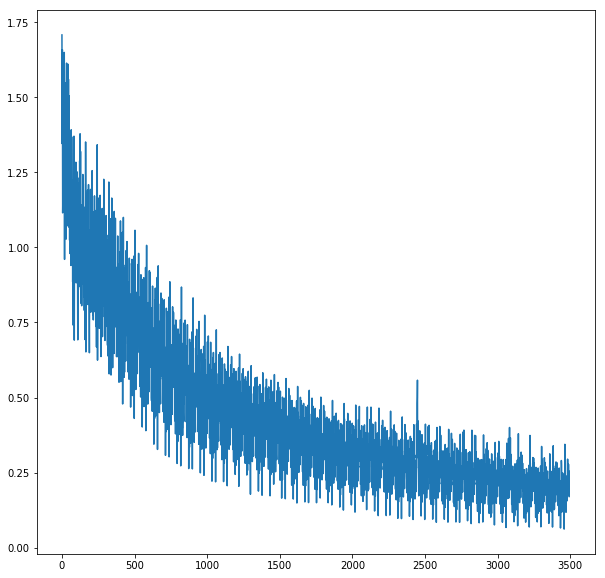

In [34]:
# plot the losses
plt.plot([l.data.cpu().numpy() for l in losses])

In [33]:
losses[0].data.cpu().numpy()

array(1.7075841, dtype=float32)

/home/ubuntu/segmentation/IS_segmentation/utils.py:16: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return cuda(Variable(x, volatile=volatile))


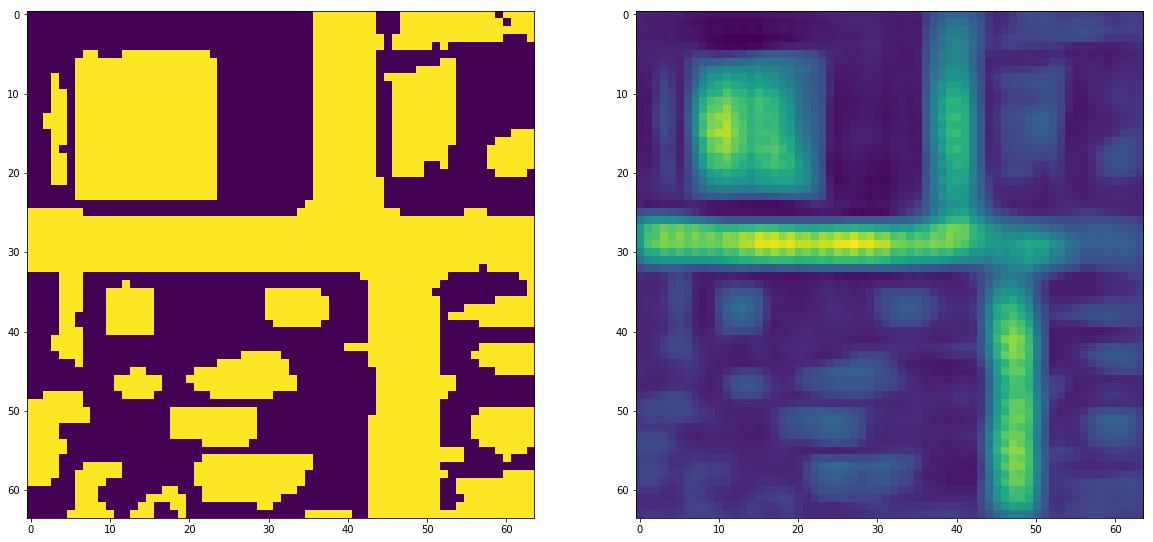

/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/ipykernel_launcher.py:22: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.


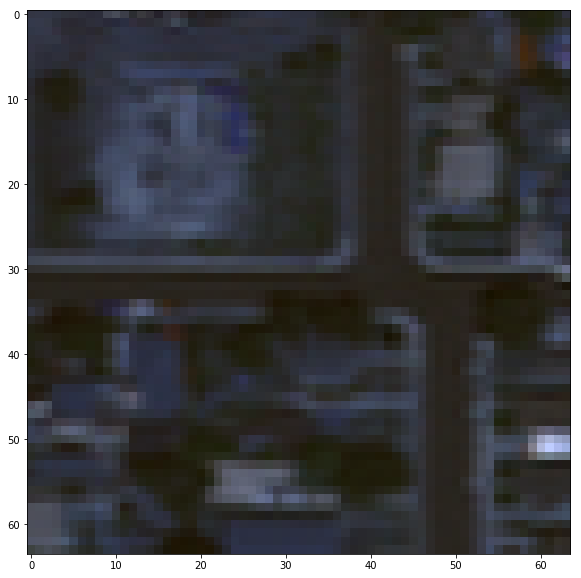

In [35]:
# check one of the test images
test_ind = 100
input_img = torch.unsqueeze(variable(dg_dataset_val[test_ind], volatile=True), dim=0) 
mask = model(input_img)


mask_im = mask.squeeze().data.cpu().numpy()
mask_binary = mask_im.copy()

fig, ax = plt.subplots(1,2, figsize=(20,10))
thresh = 0
mask_binary[mask_im<=thresh] = 0
mask_binary[mask_im>thresh] = 1
ax[0].imshow(mask_binary)
# ax[0].colorbar()
gt_im = gt_dataset_val[test_ind].numpy().squeeze()
ax[1].imshow(mask_im)
# ax[1].colorbar()
plt.show()

source_im = dg_dataset_val[test_ind].numpy()
plt.imshow(misc.bytescale(np.rollaxis(source_im, 0, 3)))
plt.show()



In [36]:
# save current state
save = lambda ep: torch.save({
        'model': model.state_dict(),
        'epoch': ep,
        'step': step,
    }, str(model_path))

root = Path('runs/debug')
model_path = root / 'model_e{}_s{}.pt'.format(epoch, step)
ep=epoch
step=i

save(ep)

In [ ]:
#load model
if model_path.exists():
    state = torch.load(str(model_path))
    epoch = state['epoch']
    step = state['step']
    model.load_state_dict(state['model'])
    print('Restored model, epoch {}, step {:,}'.format(epoch, step))